In [113]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import gpytorch
import tqdm

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.kernels import CMEAggregateKernel
from src.means import CMEAggregateMean
from src.models import ExactCMEProcess
from src.structures import BagDataset

def list_collate(batch):
    data, target = zip(*batch)
    return list(data), torch.Tensor(target)

In [192]:
# Load aerobag dataframe
df_path = '../../aerobag-dataset/sandbox/aerobag-01-04-20.csv'
df = pd.read_csv(dataset_path, index_col='index')

df.sample(n=5)

,Unnamed: 0,MODIS_Longitude(Degree),MODIS_Latitude(Degree),b01,b02,b03,b04,b05,b06,b07,...,SolarZenith,AERONET_Site_Name,AERONET_Instrument_Number,Day_of_Year,Data_Quality_Level,Site_Longitude(Degrees),Site_Latitude(Degrees),Site_Elevation(m),AOD_500nm,bag_index
index,,,,,,,,,,,,,,,,,,,,,
166,9870,8.159113,49.056468,975.0,2228.0,499.0,799.0,2824.0,2324.0,1408.0,...,4762.0,Karlsruhe,325,92,lev20,8.427900,49.093300,140.0,0.099849,24
203,1015,4.327131,50.754781,898.0,2357.0,585.0,855.0,2684.0,2128.0,1503.0,...,5029.0,Brussels,398,92,lev20,4.350000,50.783332,120.0,0.108949,3
114,11318,2.956457,45.890900,1098.0,4030.0,631.0,1062.0,4068.0,2817.0,1422.0,...,4663.0,Aubiere_LAMP,941,92,lev20,3.111072,45.760960,423.0,0.123646,27
370,4797,2.084789,48.774780,933.0,1741.0,596.0,867.0,1670.0,1622.0,1168.0,...,4401.0,Palaiseau,1044,92,lev20,2.215000,48.711600,156.0,0.111697,12
362,2289,18.114435,50.054570,793.0,2707.0,412.0,773.0,2458.0,1865.0,1308.0,...,4617.0,Raciborz,860,92,lev20,18.191700,50.083100,230.0,0.096069,7


In [169]:
# Standardize dataframe
df = (df - df.mean()) / df.std()

In [170]:
# Instantiate bag dataset out of it
bags_columns = ['MODIS_Longitude(Degree)', 'MODIS_Latitude(Degree)',
                'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'SensorAzimuth',
                'SensorZenith', 'SolarAzimuth', 'SolarZenith']
n_bags = norm_df['bag_index'].max()
bags_sizes = df.groupby('bag_index').count()['AOD_500nm'].values

individuals = [df[df.bag_index == idx][bags_columns].values for idx in df.bag_index.unique()]
bags = df[['Site_Longitude(Degrees)', 'Site_Latitude(Degrees)', 'Site_Elevation(m)']].drop_duplicates().values
aggregate_targets = df.AOD_500nm.drop_duplicates().values

dataset = BagDataset(bags=individuals, labels=aggregate_targets)
dataset

Number of bags : 29 
Dimensionality : 13 
Number of individuals : 13204 
Data type : float64

In [171]:
# Create CME Process
individuals_mean = gpytorch.means.ZeroMean()
individuals_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.arange(13), 
                                                   ard_num_dims=13)
bag_kernel = gpytorch.kernels.LinearKernel(active_dims=torch.arange(3), 
                                           ard_num_dims=3)

In [186]:
individuals_tensors = torch.from_numpy(dataset.bags).float()
bags_tensor = torch.from_numpy(bags).float()
aggregate_targets_tensor = torch.from_numpy(aggregate_targets).float()


model = ExactCMEProcess(individuals_mean=individuals_mean, 
                        individuals_kernel=individuals_kernel,
                        bag_kernel=bag_kernel,
                        train_individuals=individuals_tensors,
                        train_bags=bags_tensor,
                        train_aggregate_targets=aggregate_targets_tensor,
                        bags_sizes=bags_sizes,
                        lbda=1e-3,
                        likelihood=gpytorch.likelihoods.GaussianLikelihood())

In [188]:
epochs = 20
model.train()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

epoch_iter = tqdm.tqdm(range(epochs), desc="Epoch")
for epoch in epoch_iter:
    optimizer.zero_grad()
    output = model(bags_tensor)
    loss = -mll(output, aggregate_targets_tensor)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.update_cme_estimate_parameters()
    epoch_iter.set_postfix(loss=loss.item())

Epoch: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it, loss=1.49]


In [190]:
foo = model.covar_module(bags_tensor).evaluate().detach()

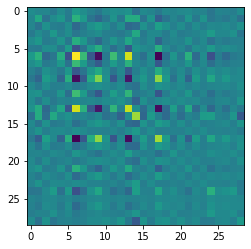

In [191]:
plt.imshow(foo)